In [1]:
import pandas as pd
import pathlib

import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns

import urllib
import joblib

2023-02-02 15:25:02.008340: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def split_data(pycytominer_output: pd.DataFrame):
    """
    split pycytominer output to metadata dataframe and np array of feature values
    Parameters
    ----------
    pycytominer_output : pd.DataFrame
        dataframe with pycytominer output
    Returns
    -------
    pd.Dataframe, np.ndarray
        metadata dataframe, feature values
    """
    # split metadata from features
    metadata_cols = [
        col_name
        for col_name in pycytominer_output.columns.tolist()
        if "efficientnet" not in col_name
    ]
    metadata_dataframe = pycytominer_output[metadata_cols]

    feature_cols = [
        col_name
        for col_name in pycytominer_output.columns.tolist()
        if "efficientnet" in col_name
    ]
    feature_data = pycytominer_output[feature_cols].values

    return metadata_dataframe, feature_data

def get_2D_umap_embeddings(feature_data: np.ndarray, random_state: int = 0):
    """
    get 2D umap embeddings for numpy array as x and y vectors
    Parameters
    ----------
    feature_data : np.ndarray
        feature data to find embeddings for
    random_state : int, optional
        random state for umap embeddings, by default 0
    Returns
    -------
    np.ndarray, np.ndarray
        X data vector, y data vector
    """
    # create umap object for dimension reduction
    reducer = umap.UMAP(random_state=random_state, n_components=2)

    # Fit UMAP and extract latent vars 1-2
    embedding = reducer.fit_transform(feature_data)
    embedding = np.transpose(embedding)

    # convert to seaborn-recognizable vectors
    x_data = embedding[0]
    y_data = embedding[1]

    return x_data, y_data

def show_2D_umap_from_embeddings(
    x_data: np.ndarray,
    y_data: np.ndarray,
    metadata_series: pd.Series,
    save_path=None,
    point_size: int = 5,
    alpha: float = 1,
    palette: str = "bright",
):
    """
    show 2D umap from 2D UMAP embeddings, save if desired
    Parameters
    ----------
    x_data : np.ndarray
        vector with X coordinates
    y_data : np.ndarray
        vector with Y coordinates
    metadata_series : pd.Series
        metadata for how to color umap points
    save_path : pathlib.Path, optional
        path to save umap image, by default None
    point_size : int, optional
        size of umap points, by default 5
    alpha : float, optional
        opacity of umap points, by default 1
    palette : str, optional
        color palette used to color points, by default "bright"
    """
    plt.figure(figsize=(15, 12))

    # Produce scatterplot with umap data, using metadata to color points
    sns_plot = sns.scatterplot(
        palette=palette,
        x=x_data,
        y=y_data,
        hue=metadata_series.tolist(),
        alpha=alpha,
        linewidth=0,
        s=point_size,
    )
    # Adjust legend
    sns_plot.legend(
        loc="center left", bbox_to_anchor=(1, 0.5), title=metadata_series.name
    )
    # Label axes, title
    sns_plot.set_xlabel("UMAP 1")
    sns_plot.set_ylabel("UMAP 2")
    sns_plot.set_title("2 Dimensional UMAP")

    # save umap
    if not save_path == None:
        plt.savefig(save_path, bbox_inches="tight")

In [3]:
gh_hash = "44e2741058c4d38edc137dc2caf5ea1f94b02410"
final_model_file_url = f"https://raw.github.com/WayScience/phenotypic_profiling_model/{gh_hash}/2.train_model/models/log_reg_model.joblib"
models_path = pathlib.Path("phenotypic_profiling_models/")
models_path.mkdir(exist_ok=True, parents=True)

log_reg_model_path = pathlib.Path(f"{models_path}/log_reg_model.joblib")
urllib.request.urlretrieve(final_model_file_url, log_reg_model_path)
log_reg_model = joblib.load(log_reg_model_path)

SQ00014611
SQ00014617
SQ00014613
SQ00014612
SQ00014618
SQ00014610
SQ00014614
SQ00014616
SQ00014615
Compiled data!


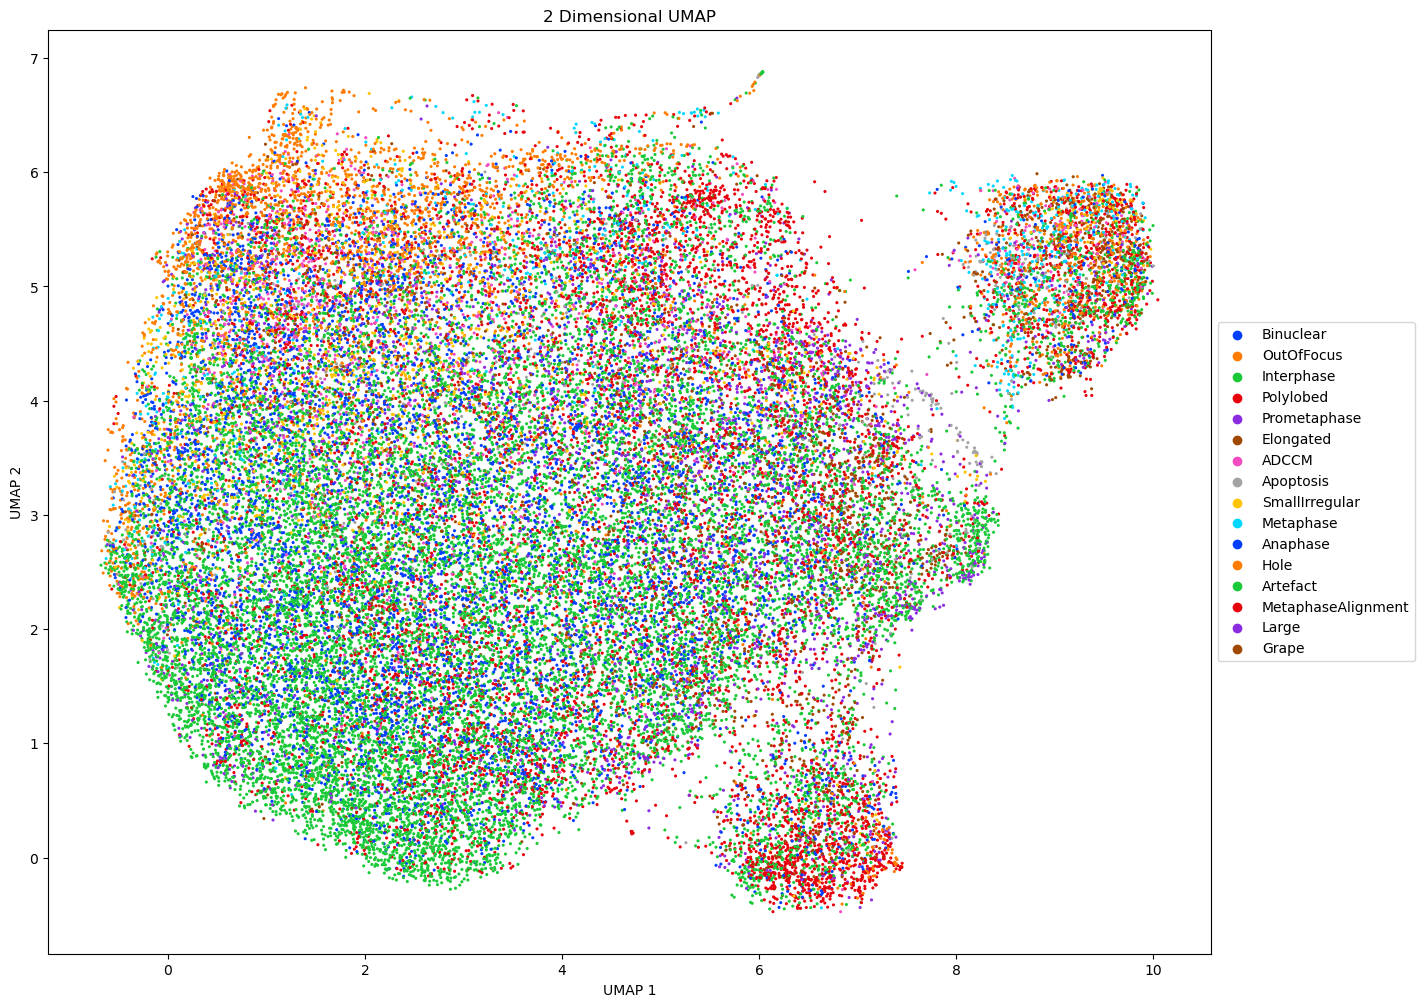

In [4]:
output_path = pathlib.Path(
    "/media/roshankern/63af2010-c376-459e-a56e-576b170133b6/data/cell-health-nuc-per-plate-normalized/"
)
results_dir = pathlib.Path("umaps/")
results_dir.mkdir(parents=True, exist_ok=True)


def test():
        compiled_normalized_plate_data = []
        compiled_normalized_plate_classes = []
    
        
        for normalized_plate_path in output_path.iterdir():
                plate = normalized_plate_path.name.replace("_normalized_single_cell.csv.gz", "")
                print(plate)

                normalized_plate_sample = pd.read_csv(
                        normalized_plate_path,
                        compression="gzip",
                        nrows=5000,
                )
                compiled_normalized_plate_data.append(normalized_plate_sample)

                feature_columns = [
                        column
                        for column in normalized_plate_sample.columns
                        if "efficientnet" in column
                ]
                sample_features = normalized_plate_sample[feature_columns].to_numpy()
                phenotypic_class_predictions = pd.Series(log_reg_model.predict(sample_features))
                compiled_normalized_plate_classes.append(phenotypic_class_predictions)

        compiled_normalized_plate_data = pd.concat(compiled_normalized_plate_data)
        compiled_normalized_plate_classes = pd.concat(compiled_normalized_plate_classes)
        
        print("Compiled data!")
        
        metadata_dataframe, feature_data = split_data(compiled_normalized_plate_data)
        x_data, y_data = get_2D_umap_embeddings(feature_data)

        show_2D_umap_from_embeddings(
                x_data,
                y_data,
                compiled_normalized_plate_classes,
                f"{results_dir}/all_plate_sample.png",
        )
        
        return


test()